# Классификация текстов

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import random
random.seed(1228)
from sklearn.feature_extraction.text import *
from sklearn.metrics import *
from sklearn.pipeline import Pipeline
import re
from pymystem3 import Mystem
import numpy as np
import itertools
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from nltk.stem.snowball import RussianStemmer
import seaborn as sns
import joblib

Разбиение на тестовое и обучающее множество

In [2]:
m = Mystem()
regex = re.compile("[А-Яа-я]+")

def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return ""

def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "

def stemming(text, stemmer = RussianStemmer()):
    try:
        return " ".join([stemmer.stem(w) for w in text.split()])
    except:
        return " "



In [3]:
from nltk.corpus import stopwords
# print(stopwords.words('russian'))

In [4]:
with open("/Users/romakindmitriy/PycharmProjects/TelegramParser/docs/stopwords/fullstopwords.txt", 'r') as f:
    stopw = f.readlines()

# print(stopw)
v_stopwords = list(set([x[:-1] for x in stopw]))
print(len(v_stopwords))

854


In [5]:
mystopwords = stopwords.words('russian') + v_stopwords
mystopwords = list(set(mystopwords))

In [6]:
def remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

In [7]:
d = pd.read_csv('./dataset_classes.csv', usecols=['message','class'])
d.head()

,message,class
0,"Нет, я вспомнил. есть хорошие новости, с котор...",2.0
1,"В Штатах, кажется, хотят сделать очень невыгод...",2.0
2,"аппаратная дыра в процессорах Intel, а точнее ...",5.0
3,Let’s Encrypt пока что не будет отзывать часть...,5.0
4,Интересное видео с выступлением менеджеров Mic...,2.0


In [8]:
filter_1 = d['class'] == 1.
filter_2 = d['class'] == 2.
filter_3 = d['class'] == 3.
filter_4 = d['class'] == 4.
filter_5 = d['class'] == 5.
# filter_6 = d['class'] == 5

data = d.loc[filter_1 | filter_2 | filter_3 | filter_4 | filter_5]
# ch = 150
# pdlist = [d[filter_1][:ch], d[filter_2][:ch], d[filter_3][:ch], d[filter_4][:ch], d[filter_5][:ch]]
# data = pd.concat(pdlist)

In [9]:
data['class'].value_counts()

3.0    799
4.0    187
1.0    122
2.0    118
5.0     64
Name: class, dtype: int64

In [10]:
data.head()

,message,class
0,"Нет, я вспомнил. есть хорошие новости, с котор...",2.0
1,"В Штатах, кажется, хотят сделать очень невыгод...",2.0
2,"аппаратная дыра в процессорах Intel, а точнее ...",5.0
3,Let’s Encrypt пока что не будет отзывать часть...,5.0
4,Интересное видео с выступлением менеджеров Mic...,2.0


In [11]:
# corpus_sample_train = pd.DataFrame(columns=data.columns)
# corpus_sample_test = pd.DataFrame(columns=data.columns)

# for cl in data['class'].unique():
#     corpus_sample = data[data['class']==cl]
#     if len(corpus_sample) > 200:
#         corpus_sample_train = corpus_sample_train.append(corpus_sample.iloc[:60,:])
#         corpus_sample_test = corpus_sample_test.append(corpus_sample.iloc[60:,:])
#     elif len(corpus_sample) > 60:
#         corpus_sample_train = corpus_sample_train.append(corpus_sample.iloc[:60,:])
#         corpus_sample_test = corpus_sample_test.append(corpus_sample.iloc[60:,:])

In [12]:
corpus_sample_train = pd.DataFrame(columns=data.columns)
corpus_sample_test = pd.DataFrame(columns=data.columns)

for cl in data['class'].unique():
    corpus_sample = data[data['class']==cl][20:120]
    corpus_sample_train = corpus_sample_train.append(corpus_sample)
    corpus_sample_test = corpus_sample_test.append(data[data['class']==cl][:20])
    corpus_sample_test = corpus_sample_test.append(data[data['class']==cl][120:])

In [13]:
len(corpus_sample_train)

442

In [14]:
len(corpus_sample_test)

848

In [15]:
corpus_sample_train.message = corpus_sample_train.message.apply(lemmatize)
corpus_sample_test.message = corpus_sample_test.message.apply(lemmatize)
corpus_sample_train.message = corpus_sample_train.message.apply(remove_stopwords)
corpus_sample_test.message = corpus_sample_test.message.apply(remove_stopwords)

In [16]:
corpus_sample_test.head()

,message,class
0,"нет, вспомнить. новость, оставлять длинный вых...",2.0
1,"штат, кажется, невыгодный шифрование продукт. ...",2.0
4,"видео выступление менеджер Microsoft, IT-безоп...",2.0
5,секретный опасност. министерство юстиция сша в...,2.0
8,"NYT то, китай технология то, определять, жител...",2.0


In [17]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier

clf = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', BaggingClassifier()),
#     RandomForestClassifier
#     ('clf', AdaBoostClassifier()),
])


clf.fit(corpus_sample_train['message'], corpus_sample_train['class'])

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...imators=10, n_jobs=None, oob_score=False, random_state=None,
         verbose=0, warm_start=False))])

In [18]:
true = corpus_sample_test['class']
predictions = clf.predict(corpus_sample_test['message'])

In [29]:
filename = 'clf_all_stopwords.sav'
joblib.dump(clf, filename)

['clf_all_stopwords.sav']

Precision:   0.55
Recall:   0.60
F1-measure:   0.50
Accuracy:   0.79
              precision    recall  f1-score   support

         1.0       0.30      0.59      0.39        22
         2.0       0.40      0.95      0.56        20
         3.0       0.92      0.85      0.89       699
         4.0       0.37      0.45      0.40        87
         5.0       0.75      0.15      0.25        20

   micro avg       0.79      0.79      0.79       848
   macro avg       0.55      0.60      0.50       848
weighted avg       0.83      0.79      0.80       848



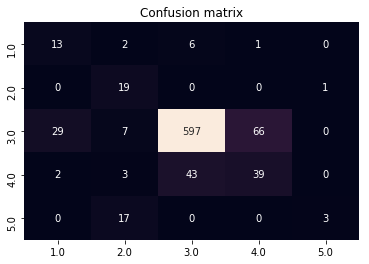

In [19]:
print("Precision: {0:6.2f}".format(precision_score(true, predictions, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(true, predictions, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(true, predictions, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(true, predictions)))
print(classification_report(true, predictions))
labels = clf.classes_



labels = clf.classes_
sns.heatmap(data=confusion_matrix(true, predictions), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

In [34]:
# print(type(corpus_sample_test['message'][1]))
clf.predict(corpus_sample_test['message'][1:2])

data = [[corpus_sample_test['message'][1]]] 
  
# Create the pandas DataFrame 
pdd = pd.DataFrame(data, columns = ['text'])
print(pdd['text'][:0])
print(type(pdd['text'][:1]))
clf.predict(pdd['text'][:1])

Series([], Name: text, dtype: object)
<class 'pandas.core.series.Series'>


array([2.])

## Классификация текстов 

По мотивам http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
from sklearn.metrics import *
from sklearn.feature_extraction.text import *
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
random.seed(1228)

%matplotlib inline

In [ ]:
from pymystem3 import Mystem
import re


m = Mystem()


regex = re.compile("[А-Яа-я:=!\)\()A-z\_\%/|]+")

def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return ""



def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "


In [ ]:
d = pd.read_csv('./dataset_classes.csv')
d.head()

In [ ]:
filter_1 = d['class'] == 1.
filter_2 = d['class'] == 2.
filter_3 = d['class'] == 3.
filter_4 = d['class'] == 4.
filter_5 = d['class'] == 5.
filter_6 = d['class'] == 5

# df = d.loc[filter_1 | filter_2 | filter_3 | filter_4 | filter_5 | filter_6]
ch = 150
pdlist = [d[filter_1][:ch], d[filter_2][:ch], d[filter_3][:ch], d[filter_4][:ch], d[filter_5][:ch]]
df = pd.concat(pdlist)

In [ ]:
# df.message.dropna(inplace = True)
# len_data = df.message.apply(len)
# len_data.describe()

In [ ]:
df.message = df.message.apply(words_only)
df.message = df.message.apply(lemmatize)

In [ ]:
# df.message = df.message.apply(remove_stopwords)

In [ ]:
df.head()

In [ ]:
texts = [df.message.iloc[i].split() for i in range(len(df))]

In [ ]:
from gensim.models import Word2Vec

model = Word2Vec(texts, size=100, window=5, min_count=5, workers=6)
model.save("sent_w2v.model")

In [ ]:
model = Word2Vec.load("sent_w2v.model")

In [ ]:
cl = len(df.message.tolist())

In [ ]:
X = df.message.tolist()
y = list(df['class'])[:cl]

X, y = np.array(X), np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33)
print ("total train examples %s" % len(y_train))
print ("total test examples %s" % len(y_test))

In [ ]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(w2v.popitem()[1])

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [ ]:
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(w2v.popitem()[1])

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [ ]:
w2v = dict(zip(model.wv.index2word, model.wv.syn0))

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier


rfc_w2v = Pipeline([
    ("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)),
    ("extra trees", RandomForestClassifier(n_estimators=20))])
rfc_w2v_tfidf = Pipeline([
    ("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v)),
    ("extra trees", RandomForestClassifier(n_estimators=20))])
rfc_w2v_tfidf_v1 = Pipeline([
    ("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v)),
    ("extra trees", BaggingClassifier())])

In [ ]:
rfc_w2v.fit(X_train,y_train)
pred = rfc_w2v.predict(X_test)

In [ ]:
filename = 'rfc_w2v.sav'
joblib.dump(rfc_w2v, filename)

In [ ]:
print("Precision: {0:6.2f}".format(precision_score(y_test, pred, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, pred, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, pred, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, pred)))
print(classification_report(y_test, pred))
labels = rfc_w2v.classes_


sns.heatmap(data=confusion_matrix(y_test, pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

In [ ]:
rfc_w2v_tfidf.fit(X_train,y_train)
pred = rfc_w2v_tfidf.predict(X_test)

In [ ]:
print("Precision: {0:6.2f}".format(precision_score(y_test, pred, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, pred, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, pred, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, pred)))
print(classification_report(y_test, pred))
labels = rfc_w2v.classes_


sns.heatmap(data=confusion_matrix(y_test, pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")

plt.show()

In [ ]:
rfc_w2v_tfidf_v1.fit(X_train,y_train)
pred = rfc_w2v_tfidf_v1.predict(X_test)

In [ ]:
print("Precision: {0:6.2f}".format(precision_score(y_test, pred, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, pred, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, pred, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, pred)))
print(classification_report(y_test, pred))
labels = rfc_w2v.classes_


sns.heatmap(data=confusion_matrix(y_test, pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()